### Importy bibliotek

In [35]:
import os
import json
import string
# import morfeusz2
import numpy as np
import pandas as pd
import operator as op
import itertools as it

from wordcloud import WordCloud
from matplotlib import pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from scipy.cluster.hierarchy import dendrogram
from nltk.corpus import PlaintextCorpusReader
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

1. Utworzenie korpusu dokumentów

In [36]:
corpus_dir = "./literatura"
corpus = PlaintextCorpusReader(corpus_dir, ".*\.txt")
files = corpus.fileids()
files

<>:2: SyntaxWarning: invalid escape sequence '\.'
<>:2: SyntaxWarning: invalid escape sequence '\.'
/var/folders/4v/mdq8tns56dj56v4326133v3w0000gq/T/ipykernel_88886/3713825801.py:2: SyntaxWarning: invalid escape sequence '\.'
  corpus = PlaintextCorpusReader(corpus_dir, ".*\.txt")


['Harry Potter i Czara Ognia.txt',
 'Harry Potter i Insygnia Smierci.txt',
 'Harry Potter i Kamien Filozoficzny.txt',
 'Harry Potter i Komnata Tajemnic.txt',
 'Harry Potter i Ksiaze Polkrwi.txt',
 'Harry Potter i Przeklete Dziecko.txt',
 'Harry Potter i Wiezien Azkabanu.txt',
 'Harry Potter i Zakon Feniksa.txt',
 'Opowiesci z Narni. Kon i jego chlopiec.txt',
 'Opowiesci z Narni. Ksiaze Kaspian.txt',
 'Opowiesci z Narni. Lew, czarownica i stara szafa.txt',
 'Opowiesci z Narni. Ostatnia bitwa.txt',
 'Opowiesci z Narni. Podroz Wedrowca do Switu.txt',
 'Opowiesci z Narni. Siostrzeniec Czarodzieja.txt',
 'Opowiesci z Narni. Srebrne krzeslo.txt',
 'Zmierzch.Ksiezyc w Nowiu.txt',
 'Zmierzch.Przed Switem.txt',
 'Zmierzch.Zacmienie.txt',
 'Zmierzch.Zmierzch.txt',
 'Zmierzch.Zycie i Smierc.txt']

2. Wstęne przygotowanie dokumentów

In [37]:
documents = {}
for  f in files:
    documents[f] = corpus.raw(f)
print(json.dumps(documents, indent=4, ensure_ascii=False))    

{
    "Harry Potter i Czara Ognia.txt": "Lord Voldemort, wraz ze swoim sługą Glizdogonem przybywa do domu należącego niegdyś do rodziny Riddle'ów położonego w Little Hangleton. Tam układają plan dotyczący zamordowania Harry'ego Pottera, co ma pomóc Czarnemu Panu w odzyskaniu jego dawnej mocy. Jest także mowa o wiernym słudze Czarnego Pana, który wkrótce ma znaleźć się w Hogwarcie. Wszystko to słyszy mieszkający nieopodal ogrodnik, Frank Bryce. Voldemort odkrywając, iż mężczyzna podsłuchuje, zaprasza go do środka i uśmierca. Harry budzi się z przerażającego snu. Jego blizna pulsuje okropnym bólem. Próbuje sobie przypomnieć o czym śnił, a z pamięci wyłania się obraz mrocznego pokoju, węża leżącego przed kominkiem oraz Glizdogona i Lorda Voldemorta planujących morderstwo. Harry zastanawia się czy powinien komuś powiedzieć o problemach z blizną, ponieważ, gdy bolała go ostatnim razem, Voldemort wdarł się do Hogwartu. Ostatecznie postanawia napisać do Syriusza i zejść na śniadanie. W trakci

In [38]:
stoplist_file = open("./stopwords_pl.txt", "r", encoding="UTF-8")
stoplist = stoplist_file.read().splitlines()
stoplist_file.close()
stoplist = stoplist[4:]
stoplist

['vol',
 'o.o.',
 'mgr',
 'godz',
 'zł',
 'www',
 'pl',
 'ul',
 'tel',
 'hab',
 'prof',
 'inż',
 'dr',
 'i',
 'u',
 'aby',
 'albo',
 'ale',
 'ani',
 'aż',
 'bardzo',
 'bez',
 'bo',
 'bowiem',
 'by',
 'byli',
 'bym',
 'był',
 'była',
 'było',
 'były',
 'być',
 'będzie',
 'będą',
 'chce',
 'choć',
 'co',
 'coraz',
 'coś',
 'czy',
 'czyli',
 'często',
 'dla',
 'do',
 'gdy',
 'gdyby',
 'gdyż',
 'gdzie',
 'go',
 'ich',
 'im',
 'inne',
 'iż',
 'ja',
 'jak',
 'jakie',
 'jako',
 'je',
 'jednak',
 'jednym',
 'jedynie',
 'jego',
 'jej',
 'jest',
 'jeszcze',
 'jeśli',
 'jeżeli',
 'już',
 'ją',
 'kiedy',
 'kilku',
 'kto',
 'która',
 'które',
 'którego',
 'której',
 'który',
 'których',
 'którym',
 'którzy',
 'lat',
 'lecz',
 'lub',
 'ma',
 'mają',
 'mamy',
 'mi',
 'miał',
 'mimo',
 'mnie',
 'mogą',
 'może',
 'można',
 'mu',
 'musi',
 'na',
 'nad',
 'nam',
 'nas',
 'nawet',
 'nic',
 'nich',
 'nie',
 'niej',
 'nim',
 'niż',
 'no',
 'nowe',
 'np',
 'nr',
 'o',
 'od',
 'ok',
 'on',
 'one',
 'oraz',
 '

In [39]:
def lemmatize(text):
    morf = morfeusz2.Morfeusz()
    segments = it.groupby(morf.analyse(text), op.itemgetter(0,1))
    def disambiguate(group):
        pairs = ((len(descr), lemma)
                 for _, _, (_, lemma, descr, _, _, ) in group)
        perpl, lemma = min(pairs)
        return lemma.split(":")[0]
    lemmas = (disambiguate(group) for key, group in segments)
    return " ".join(filter(str.isalpha, lemmas))

In [40]:
for key in documents:
    documents[key] = documents[key].lower()
    documents[key] = "".join([char for char in documents[key] if char not in string.punctuation])
    documents[key] = lemmatize(documents[key])
    documents[key] = " ".join([word for word in word_tokenize(documents[key], language='polish') if word not in stoplist])

    print(json.dumps(documents, indent=4, ensure_ascii=False))

NameError: name 'morfeusz2' is not defined

### 3. Utworzenie macierzy częstości

In [41]:
docs = pd.DataFrame.from_dict(documents, orient='index')
docs.columns = ['content']
docs

,content
Harry Potter i Czara Ognia.txt,lord voldemort wraz ze swoim sługą glizdogonem...
Harry Potter i Insygnia Smierci.txt,"Podczas zebrania śmierciożerców, które odbywa ..."
Harry Potter i Kamien Filozoficzny.txt,Na ulicy Privet Drive pojawia się stary człowi...
Harry Potter i Komnata Tajemnic.txt,"Wuj Vernon jest zły, że Hedwiga robi bałagan w..."
Harry Potter i Ksiaze Polkrwi.txt,Mugolskiego premiera odwiedza Korneliusz Knot ...
Harry Potter i Przeklete Dziecko.txt,"Scena pierwsza oraz druga opowiada historię, k..."
Harry Potter i Wiezien Azkabanu.txt,Harry leży pod kocami w łóżku i odrabia prace ...
Harry Potter i Zakon Feniksa.txt,Dudley jest zły i wyżywa się na Harrym. Dudley...
Opowiesci z Narni. Kon i jego chlopiec.txt,Akcja książki rozgrywa się w Narnii za czasów ...
Opowiesci z Narni. Ksiaze Kaspian.txt,"Mija rok od wydarzeń opisanych w powieści ""Lew..."


In [42]:
count_vectorizer = CountVectorizer()
counts_tf = count_vectorizer.fit_transform(docs['content'])
counts_tf.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(20, 7485))

In [43]:
tfidfcount_vectorizer = TfidfVectorizer()
counts_tfidf = tfidfcount_vectorizer.fit_transform(docs['content'])
counts_tfidf.toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.01353591, 0.01706547, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], shape=(20, 7485))

### 4. Chmury tagów

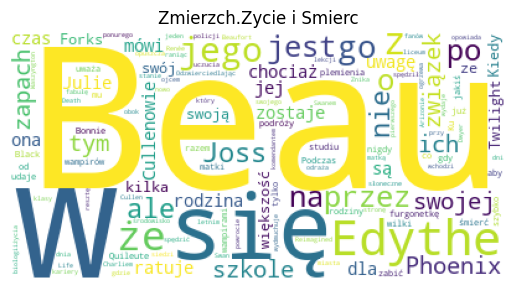

In [44]:
wordcloud = WordCloud(
    background_color='white',
    max_words=5000,
    contour_width=3,
    contour_color='steelblue'
)
if not os.path.exists("./chmury"):
    os.mkdir("./chmury")
for index, row in docs.iterrows():
    wordcloud.generate(row['content'])
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title(index.replace(".txt", ""))
    plt.savefig("./chmury/{}".format(index.replace(".txt", ".png")))

### 5. Topic modelling

In [45]:
if not os.path.exists("./tematy"):
    os.mkdir("./tematy")
def plot_top_words(model, feature_names, n_top_words, title, subplots):
    fig, axes = plt.subplots(*subplots, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[-n_top_words:]
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.savefig(f"./tematy/{title}.png")
    plt.close()

In [46]:
def plot_documents(model, counts, files_names, n_components, title):
  colors = ['forestgreen', 'lightskyblue', 'hotpink', 'turquoise', 'steelblue', 'crimson', 'seagreen', 'orange']
  docs_topics = pd.DataFrame(model.transform(counts), columns=[f"Topic {x}" for x in range(n_components)])
  docs_topics.index = [file_name.replace(".txt", "") for file_name in files_names]
  plt.figure(figsize=(7,4))
  left = [0] * len(docs_topics)
  for i, col in enumerate(docs_topics.columns):
    plt.barh(docs_topics.index, docs_topics[col], left=left, label=col, color = colors[i])
    left = [left[j]+docs_topics[col].iloc[j] for j in range(len(docs_topics))]
  plt.savefig(f"./tematy/{title}_docs.png")
  plt.close()

In [47]:
n_components = 3
feature_names = count_vectorizer.get_feature_names_out()
n_top_words = 20
subplots = (1,3)

In [48]:
lda = LatentDirichletAllocation(
    n_components=n_components,
    max_iter=5,
    learning_method='online',
    learning_offset=50,
    random_state=0
)
lda.fit(counts_tf)
plot_top_words(lda, feature_names, n_top_words, "Tematy w modelu LDA", subplots)
plot_documents(lda, counts_tf, files, n_components, "Tematy w modelu LDA")

In [49]:
nmf_fn = NMF(
    n_components=n_components,
    random_state=1,
    alpha_H=.00005,
    alpha_W=.00005,
    l1_ratio=.5
)
nmf_fn.fit(counts_tfidf)
plot_top_words(nmf_fn, feature_names, n_top_words, "Tematy w modelu NMF (FN)", subplots)
plot_documents(nmf_fn, counts_tfidf, files, n_components, "Tematy w modelu NMF (FN)")

In [50]:
nmf_kl = NMF(
    n_components=n_components,
    random_state=1,
    beta_loss='kullback-leibler',
    solver='mu',
    max_iter=1000,
    alpha_H=.00005,
    alpha_W=.00005,
    l1_ratio=.5
)
nmf_kl.fit(counts_tfidf)
plot_top_words(nmf_kl, feature_names, n_top_words, "Tematy w modelu NMF (KL)", subplots)
plot_documents(nmf_kl, counts_tfidf, files, n_components, "Tematy w modelu NMF (KL)")

### 6. Analiza skupień

In [51]:
def plot_dendrogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)
    dendrogram(linkage_matrix, **kwargs)

In [52]:
if not os.path.exists("./skupienia"):
    os.mkdir("./skupienia")
colors = ['forestgreen', 'lightskyblue', 'hotpink', 'turquoise', 'steelblue', 'crimson', 'seagreen', 'orange']

In [53]:
cs = cosine_similarity(counts_tfidf, counts_tfidf).flatten().reshape(20, 20)
cs

array([[1.        , 0.62338675, 0.58365193, 0.56124706, 0.59082029,
        0.55973323, 0.63381906, 0.55169773, 0.15449387, 0.35877538,
        0.32457939, 0.16390498, 0.40214811, 0.1371414 , 0.14547745,
        0.28048648, 0.31490605, 0.28770585, 0.28289187, 0.1758905 ],
       [0.62338675, 1.        , 0.66345857, 0.64108491, 0.70656878,
        0.5783721 , 0.66429993, 0.71961412, 0.11825785, 0.25400953,
        0.23456953, 0.13538862, 0.27266027, 0.10059453, 0.11154319,
        0.20582404, 0.21815968, 0.19776474, 0.19677926, 0.12426871],
       [0.58365193, 0.66345857, 1.        , 0.62244965, 0.62898684,
        0.53791191, 0.61205044, 0.60995845, 0.11323428, 0.2732246 ,
        0.25935966, 0.12854224, 0.3111317 , 0.09593407, 0.12055551,
        0.21732745, 0.22935771, 0.21427679, 0.20759848, 0.13355895],
       [0.56124706, 0.64108491, 0.62244965, 1.        , 0.65400758,
        0.51312211, 0.58918263, 0.59875706, 0.10999821, 0.2621629 ,
        0.25026258, 0.12996864, 0.28239558, 0

In [54]:
clustering = AgglomerativeClustering(
    n_clusters=6,
    metric="euclidean",
    linkage="ward",
    compute_distances=True
).fit(cs)
clustering.labels_

array([3, 3, 3, 3, 3, 3, 3, 3, 5, 1, 1, 0, 1, 0, 0, 2, 2, 2, 2, 4])

In [55]:
plot_dendrogram(
    clustering,
    labels = files,
    truncate_mode = 'level',
    orientation = 'right',
)
plt.savefig("./skupienia/cosine_ward.png")
plt.close()

In [56]:
ed = euclidean_distances(counts_tf, counts_tf).flatten().reshape(20, 20)
ed


array([[  0.        , 219.94090115, 249.12446688, 268.70243765,
        252.4717806 , 208.58331669, 239.92498828, 265.22820363,
        334.42338435, 268.34120071, 279.47092872, 335.82584772,
        293.9931972 , 335.5488042 , 334.23644326, 309.38648969,
        304.91638198, 317.83014332, 317.35784219, 319.6717066 ],
       [219.94090115,   0.        ,  95.16827202, 106.83164325,
         93.29523032, 108.53110153,  93.09135298,  92.44457799,
        169.29559947, 142.25681003, 149.30505685, 170.30267173,
        144.81712606, 170.30854353, 169.12717109, 154.41502518,
        151.57176518, 158.62534476, 158.57490344, 161.04036761],
       [249.12446688,  95.16827202,   0.        ,  66.633325  ,
         73.12318374, 113.98245479,  72.44998275,  77.67238892,
        120.86355944, 104.63269088, 110.81064931, 121.3424905 ,
         96.71090942, 121.72099244, 120.22063051, 107.28932845,
        104.78072342, 109.74060324, 110.40380428, 113.31813624],
       [268.70243765, 106.83164325,  

In [57]:
clustering = AgglomerativeClustering(
    n_clusters=6,
    metric="precomputed",
    linkage="complete",
    compute_distances=True
).fit(ed)
clustering.labels_

array([3, 5, 0, 0, 0, 4, 0, 0, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [58]:
plot_dendrogram(
    clustering,
    labels = files,
    truncate_mode = 'level',
    orientation = 'right',
)
plt.savefig("./skupienia/euclidean_complete.png")
plt.close()

### 7. N-gramy

In [59]:
for title in documents_tokenized:
    documents_tokenized[key] = word_tokenize(documents[key], language='polish')
print(json.dumps(documents_tokenized, indent=4, ensure_ascii=False))

{}


In [60]:
if not os.path.exists("./ngramy"):
    os.mkdir("./ngramy")
n_count = 3
if not os.path.exists(f"./ngramy/{n_count}"):
    os.mkdir(f"./ngramy/{n_count}")
for title in documents_tokenized:
    n_gram = pd.Series(ngrams(documents_tokenized[title], n_count)).value_counts()
    n_gram[:5].plot.barh()
    plt.savefig(f"./ngramy/{n_count}/{title.replace('.txt', '.png')}")
    plt.close()

In [61]:
texts = " ".join(docs['content']).split(" ")
n_gram = pd.Series(ngrams(texts, 3)).value_counts()
n_gram[:15].plot.barh()
plt.gcf().subplots_adjust(left=0.4)
plt.savefig("./ngramy/all.png")
plt.close()